# 2024-026 Exhaustion vs Effector Regions Analysis

This notebook is an exploration on the similarity of Runx3-responsive regions to naive regions.

## Initialize Environment

In [1]:
# Load necessary packages
library(tidyr)
library(dplyr)
library(ggplot2)
library(viridis)

# Set the working directory
setwd("/home/dalbao/2024-026-Tcf7ATAC/02_bp_notebooks")

daps_comparison <- "daps/241231-bp-reAnalysis-JSB-DAPS.csv"
specific_comparison <- "Exhausted_vs_Effector"
p_filter_master <- 0.1
log2FC_filter_master <- 0.5



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: viridisLite



In [2]:
# Load data
da_daps <- read.csv("daps/241231-bp-DAnST-DAPS-Unannotated.csv")
df_daps <- read.csv(daps_comparison)

table(da_daps$comparison)
table(df_daps$comparison)


               CX3CR1pos_shCD19   CX3CR1pos_shCD19_vs_D5_shCD19 
                          47192                           45362 
              CX3CR1pos_shRunx3 CX3CR1pos_shRunx3_vs_D5_shRunx3 
                          47192                           47192 
    CX3CR1pos_shRunx3_vs_shCD19             CX3CR1pos_vs_GFPneg 
                          30723                           47192 
            CX3CR1pos_vs_GFPpos            D5_shRunx3_vs_shCD19 
                          47192                           40787 
                  GFPneg_shCD19      GFPneg_shCD19_vs_D5_shCD19 
                          47192                           47192 
                 GFPneg_shRunx3    GFPneg_shRunx3_vs_D5_shRunx3 
                          47192                           45362 
       GFPneg_shRunx3_vs_shCD19                GFPneg_vs_GFPpos 
                          34383                           47192 
                  GFPpos_shCD19      GFPpos_shCD19_vs_D5_shCD19 
                        


             Effector             Exhausted Exhausted_vs_Effector 
                47192                 47192                 47192 
  Exhausted_vs_Memory                Memory    Memory_vs_Effector 
                47192                 47192                 47192 
                 MPEC                  SLEC          SLEC_vs_MPEC 
                47192                 47192                 47192 

In [3]:
# Limit the scope of the comparison
da_daps <- da_daps[grepl("shRunx3_vs_", da_daps$comparison) & !(grepl("D5", da_daps$comparison)), ]
df_daps <- df_daps[df_daps$comparison == specific_comparison, ]

table(da_daps$comparison)
table(df_daps$comparison)


CX3CR1pos_shRunx3_vs_shCD19    GFPneg_shRunx3_vs_shCD19 
                      30723                       34383 
   GFPpos_shRunx3_vs_shCD19           shRunx3_vs_shCD19 
                      39872                       46277 


Exhausted_vs_Effector 
                47192 

# Processing

In [4]:
# Identify differentially accessible peaks in the DA experiment
# Then, create a column called change that indicates the direction of the change
# if log2FC > 0, change = "closed"
# if log2FC < 0, change = "opened"
# Then, keep only the comparison, name and change columns
# Lastly, make a new column called set that pastes the values of comparison and change
da_daps <- da_daps %>%
    filter(padj < p_filter_master) %>%
    filter(abs(log2FC) > log2FC_filter_master) %>%
    mutate(change = ifelse(log2FC > 0, "closed", "opened")) %>%
    mutate(set = paste(comparison, change, sep = "_")) %>% 
    select(set, name)

head(da_daps)

# Select only name, log2FC and padj columns of df_daps
df_daps <- df_daps %>%
    select(name, log2FC, padj)

head(df_daps)

set                      name           
1 shRunx3_vs_shCD19_closed Interval_268847
2 shRunx3_vs_shCD19_closed Interval_214810
3 shRunx3_vs_shCD19_closed Interval_263547
4 shRunx3_vs_shCD19_closed Interval_102482
5 shRunx3_vs_shCD19_closed Interval_103538
6 shRunx3_vs_shCD19_closed Interval_268772

name            log2FC   padj         
330345 Interval_116808 5.215905 8.542169e-114
330346 Interval_63473  4.117494  3.057014e-71
330347 Interval_115783 2.814187  1.001387e-66
330348 Interval_200901 3.814842  7.365348e-64
330349 Interval_177651 3.690366  4.049711e-62
330350 Interval_218803 3.460503  5.153377e-60

## Ploting

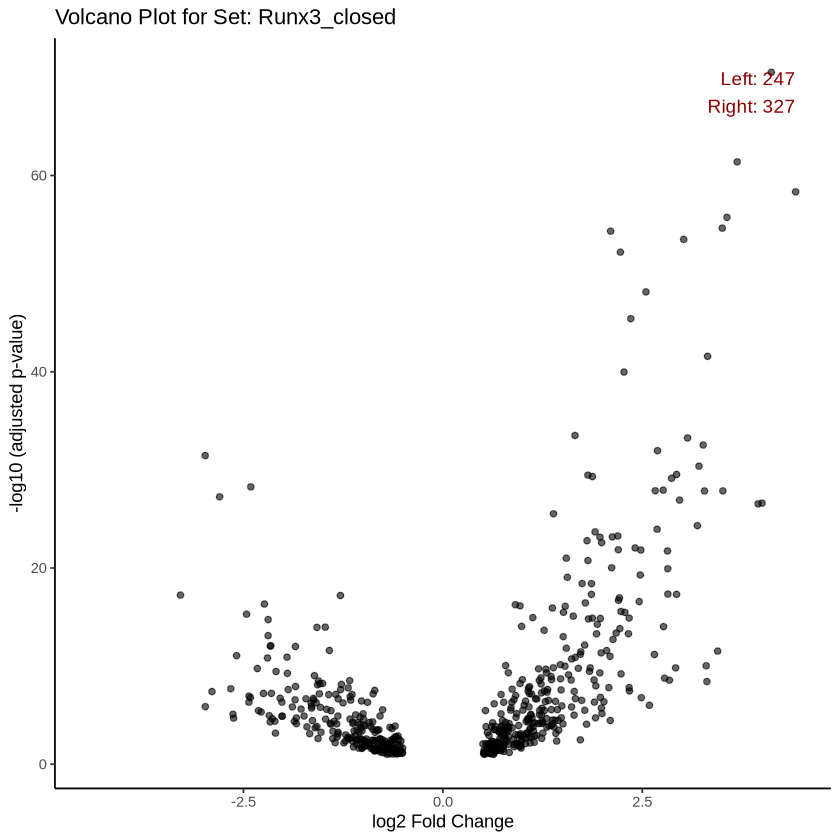

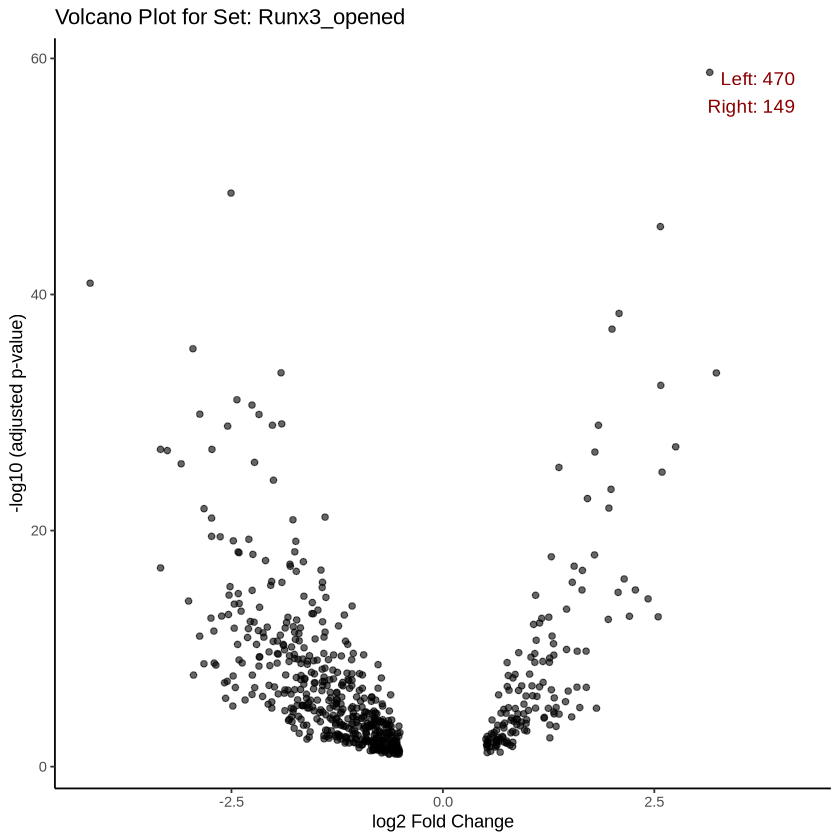

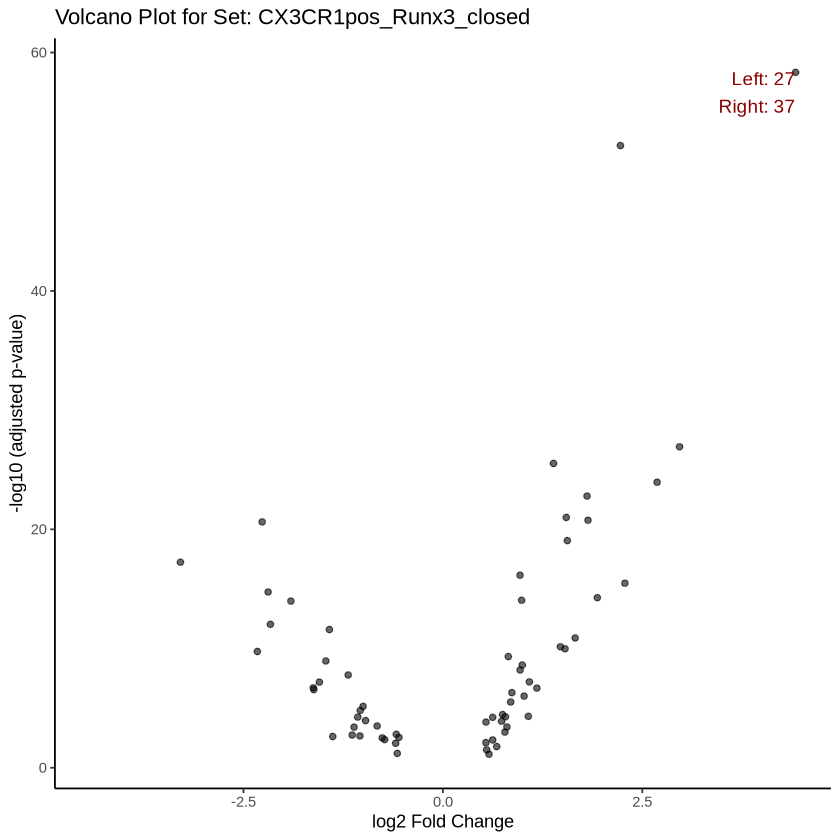

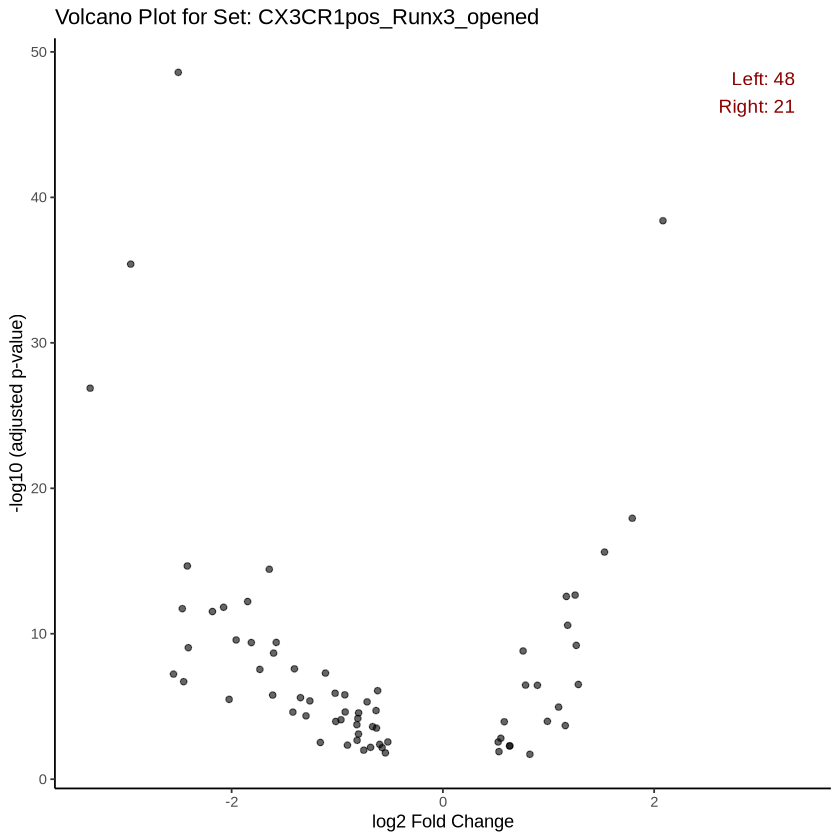

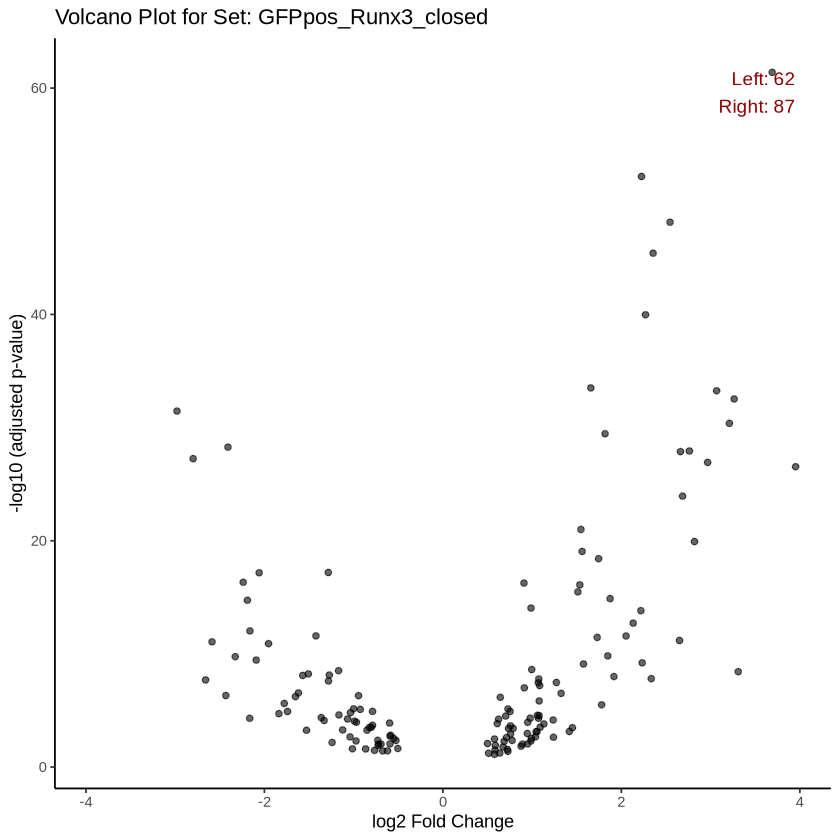

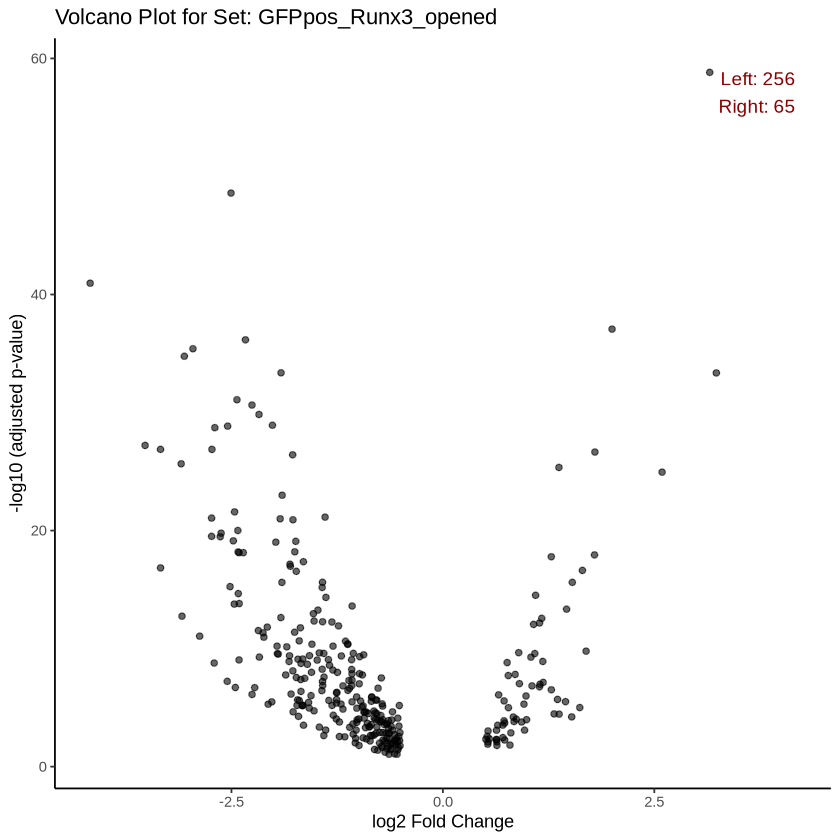

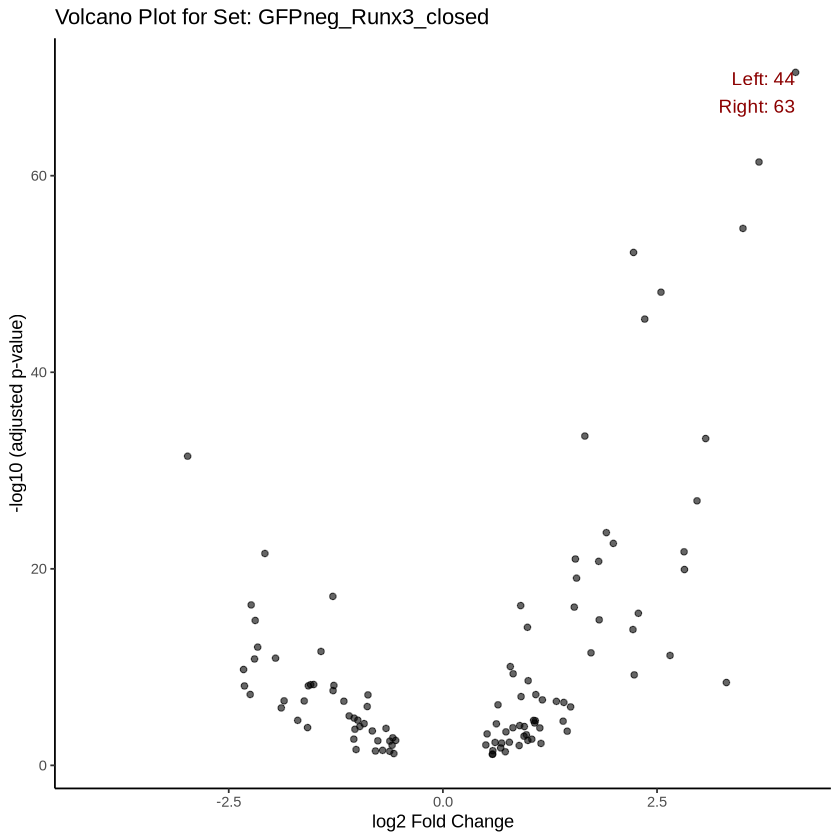

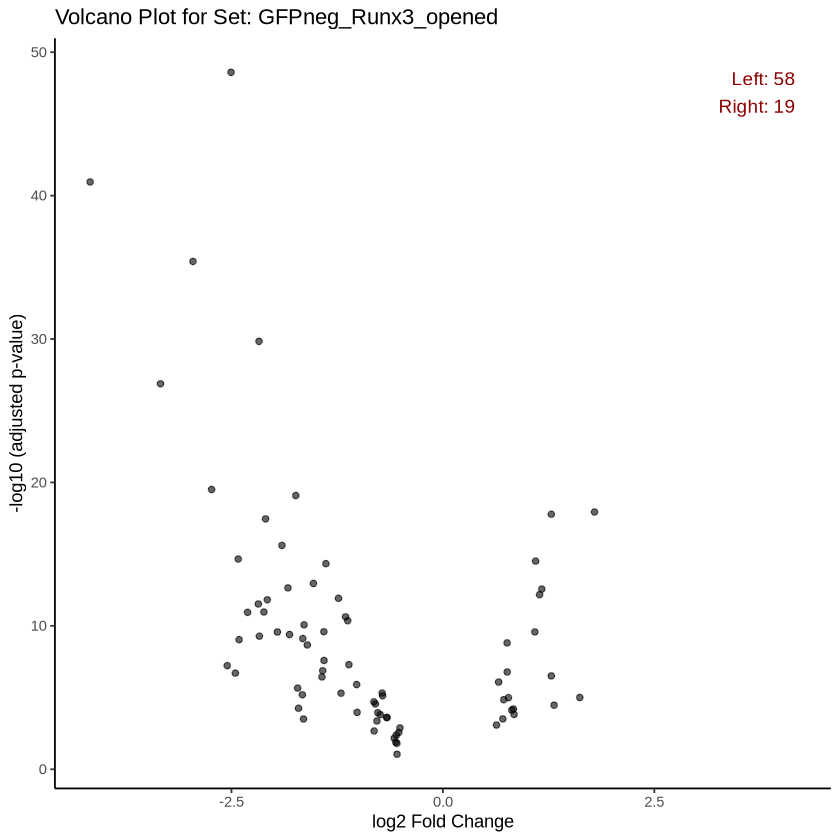

In [5]:
plot_volcano <- function(peak_set, daps, p_filter = p_filter_master, log2FC_filter = log2FC_filter_master, title_addendum = "") {
    # -----------------------------------------------------------
    # 1) Identify unique sets in peak_set
    # -----------------------------------------------------------
    unique_sets <- unique(peak_set$set)

    # -----------------------------------------------------------
    # 2) For each set, create a volcano plot of daps 
    #    (subset to only peaks in that set) and annotate 
    #    left/right counts
    # -----------------------------------------------------------
    for (s in unique_sets) {

        # ---------------------------------------------------------
        # 2a) Extract the peak names for the current set
        # ---------------------------------------------------------
        peaks_in_set <- peak_set %>%
            filter(set == s) %>%
            pull(name)

        # ---------------------------------------------------------
        # 2b) Subset daps to retain only these peaks and filter for significance
        # ---------------------------------------------------------
        daps_subset <- daps %>%
            filter(name %in% peaks_in_set) %>%
            filter(padj < p_filter) %>%
            filter(abs(log2FC) > log2FC_filter)

        # If there are no peaks in daps for this set, skip plotting
        if (nrow(daps_subset) == 0) {
            cat("No peaks in daps for set:", s, "\n")
            next
        }

        # ---------------------------------------------------------
        # 2c) Count how many of these subsetted peaks have log2FC 
        #     on the left side (log2FC < 0) or right side (log2FC > 0)
        # ---------------------------------------------------------
        left_count  <- sum(daps_subset$log2FC < 0, na.rm = TRUE)
        right_count <- sum(daps_subset$log2FC > 0, na.rm = TRUE)

        # ---------------------------------------------------------
        # 2d) Create a volcano plot with these subsetted peaks only
        # ---------------------------------------------------------
        # x-axis: log2FC
        # y-axis: -log10(padj)
        # Each plot is titled with the current set identifier

        # Define the maximum x and y for annotation placement
        max_x <- max(abs(daps_subset$log2FC), na.rm = TRUE)
        max_y <- max(-log10(daps_subset$padj), na.rm = TRUE)

        # Prepare annotation text with left and right counts
        label_text <- paste0("Left: ", left_count, "\nRight: ", right_count)

        # Create the ggplot
        p <- ggplot(daps_subset, aes(x = log2FC, y = -log10(padj))) +
            geom_point(alpha = 0.6) +  # Scatter plot with slight transparency
            theme_classic() +
            labs(
            title = paste("Volcano Plot for Set:", gsub("shRunx3_vs_shCD19", "Runx3", s), title_addendum),
            x = "log2 Fold Change",
            y = "-log10 (adjusted p-value)"
            ) +
            # Annotate the plot with the left/right counts
            annotate(
            "text",
            x = max_x,
            y = max_y,
            label = label_text,
            hjust = 1,       # move text anchor to the right
            vjust = 1,       # move text anchor to the top
            size = 4,        # text size
            color = "darkred"  # text color changed to dark red
            ) +
            # Set the x-axis limits to be equal on both sides of 0
            xlim(-max_x, max_x)

        # ---------------------------------------------------------
        # 2e) Print the plot
        # ---------------------------------------------------------
        print(p)
    }
}
# Implement
plot_volcano(da_daps, df_daps, p_filter = 0.1)

## Tcf7 Bound Peaks Analysis

Check the enrichment of Tcf7-bound Runx3-controlled peaks in Tcm vs naive.

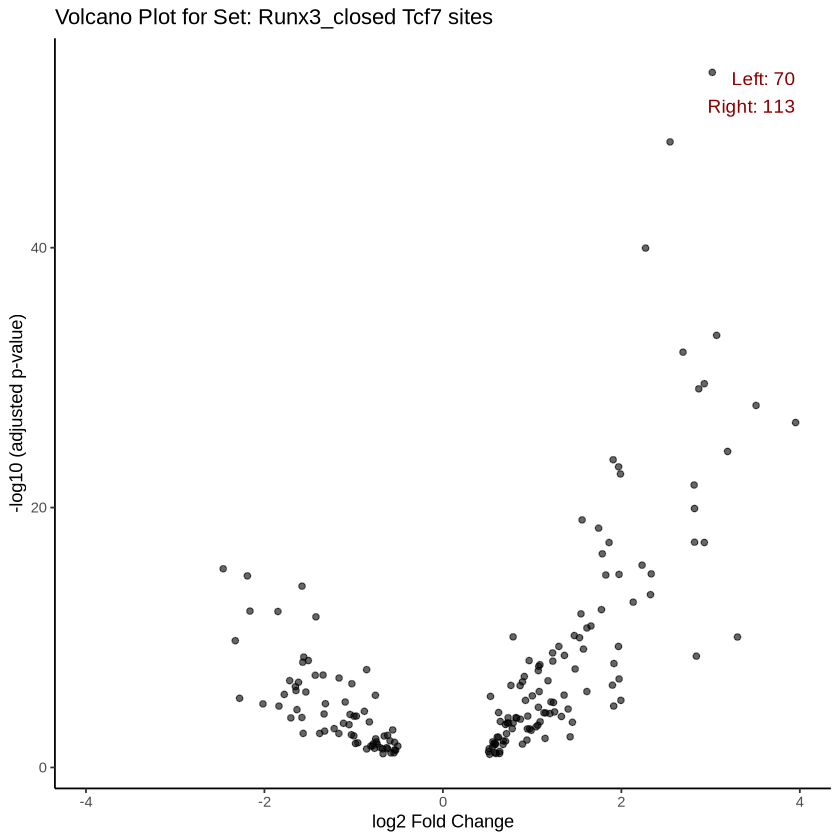

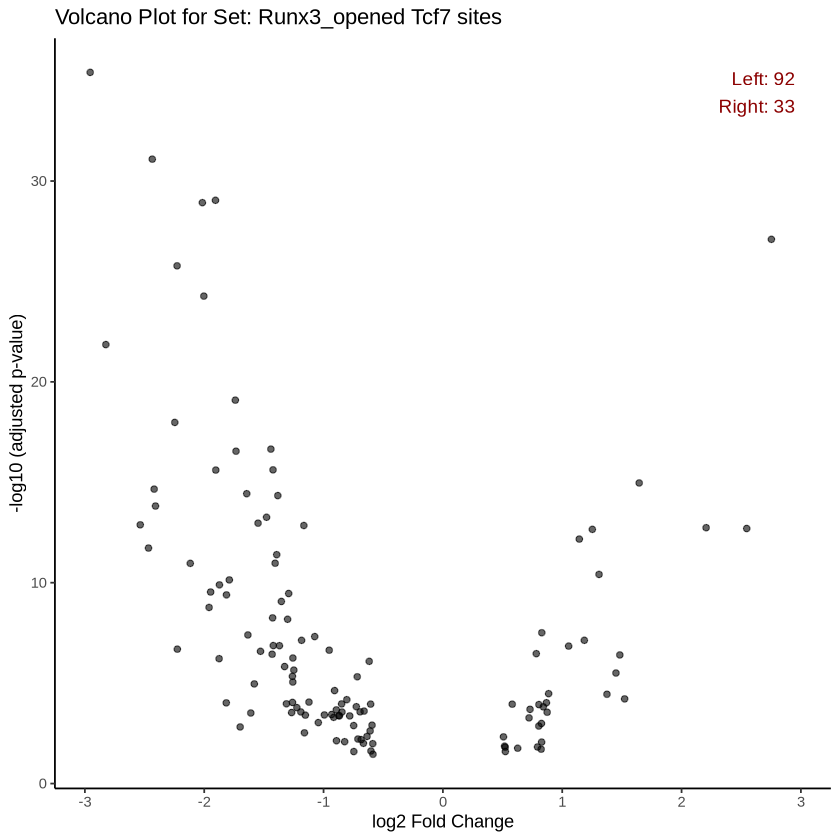

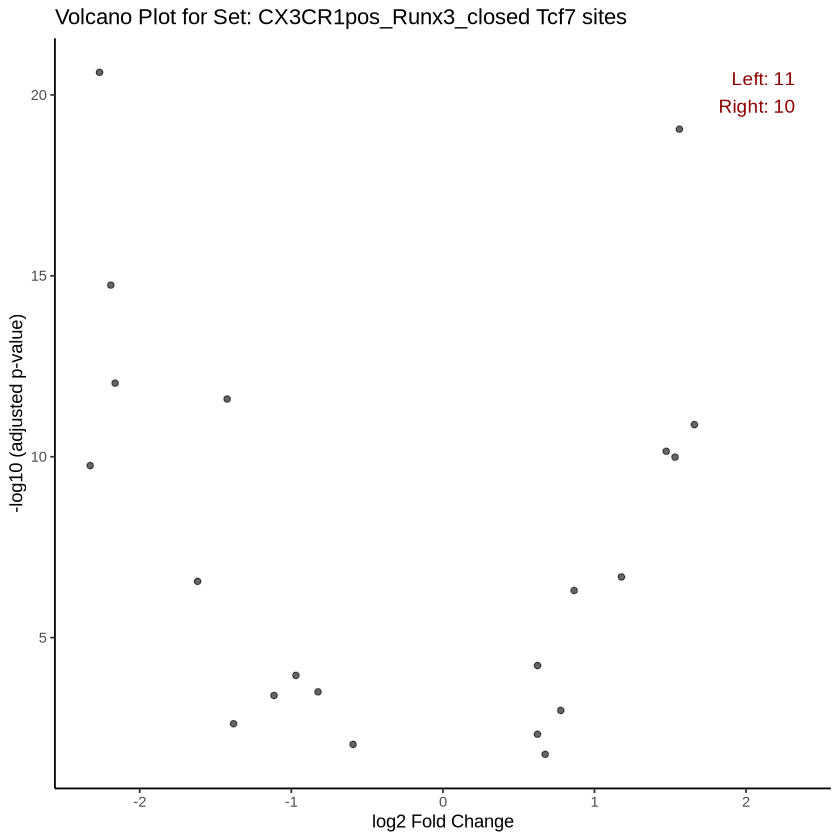

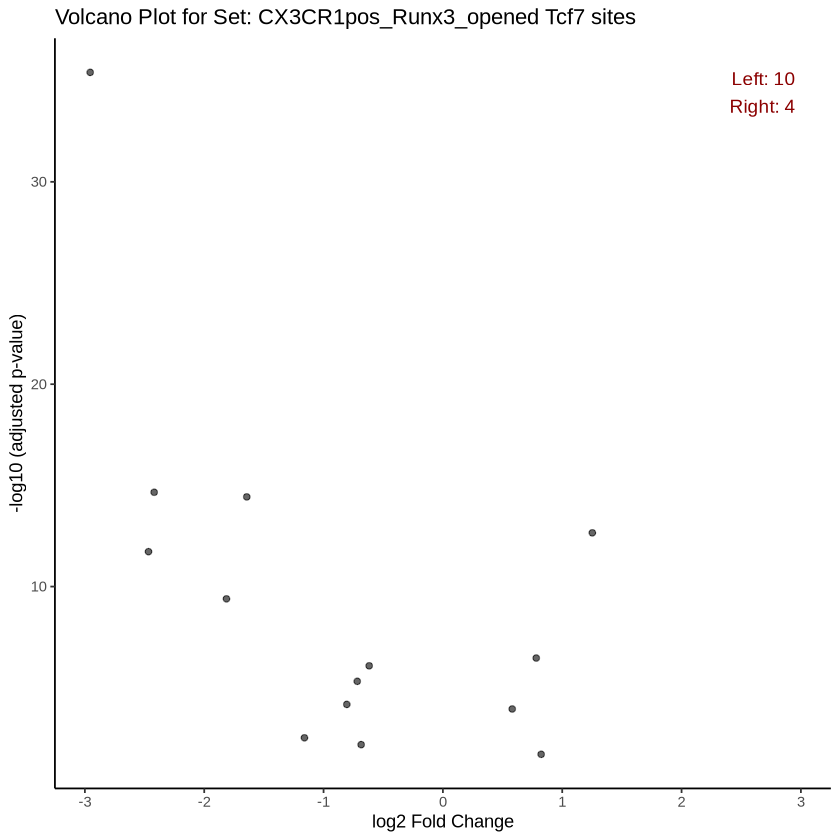

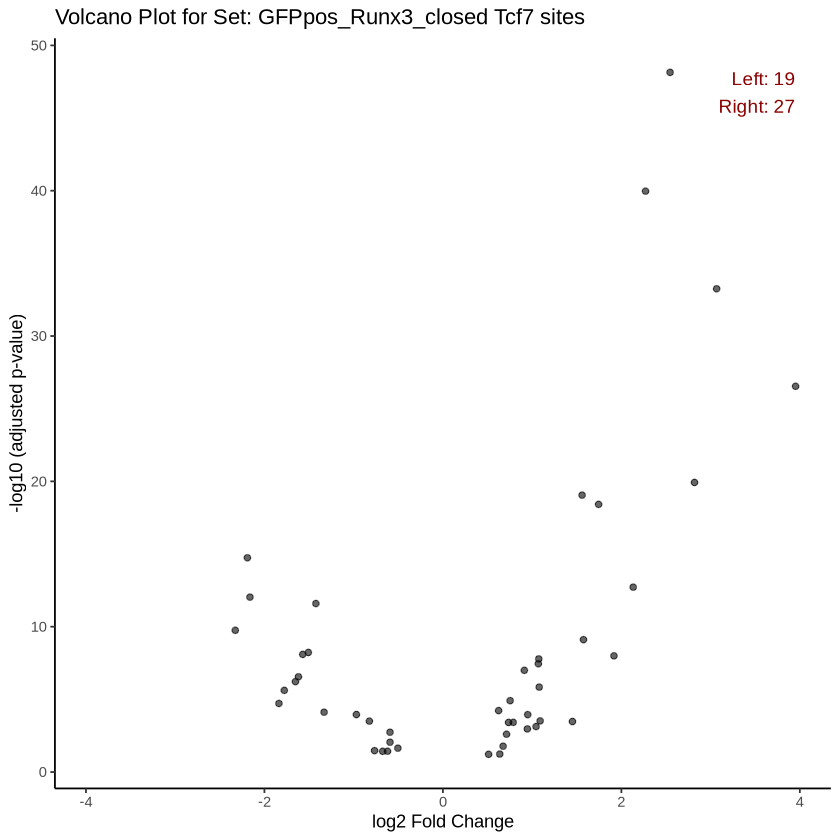

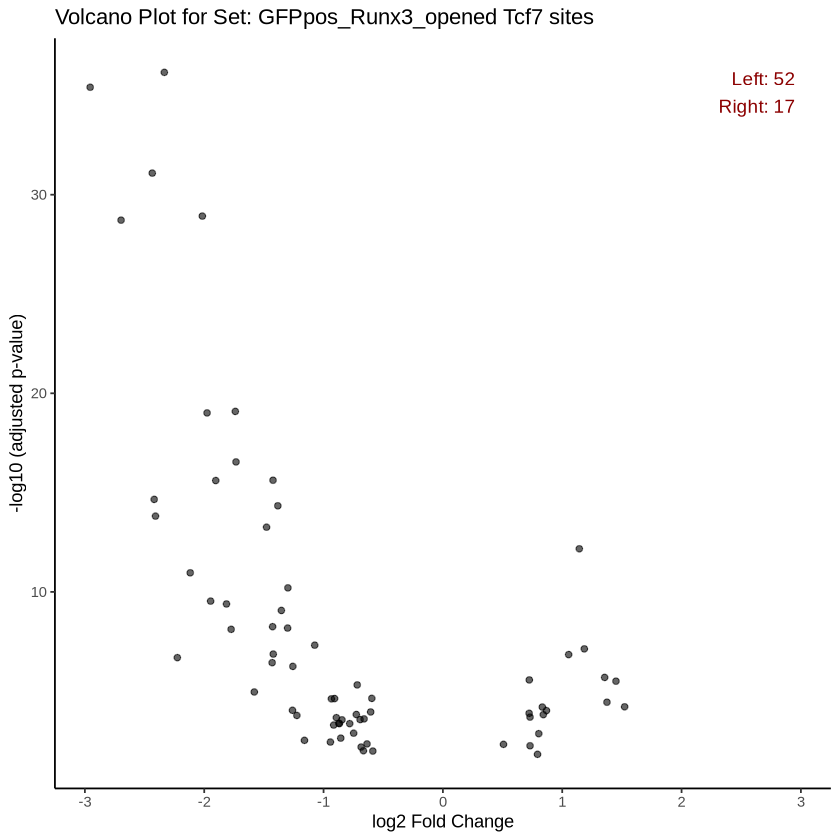

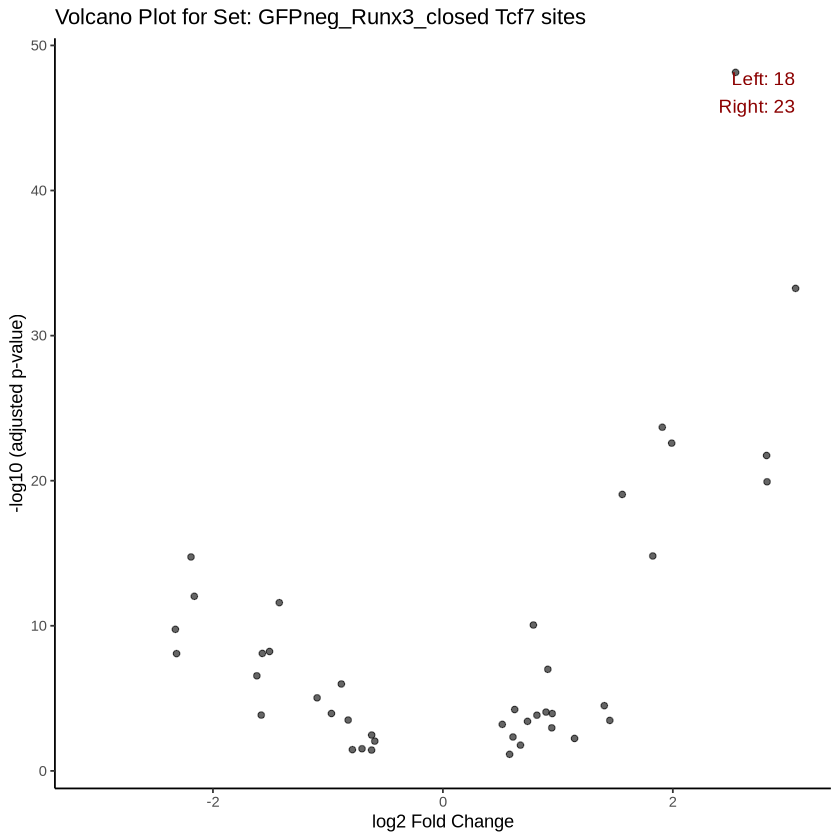

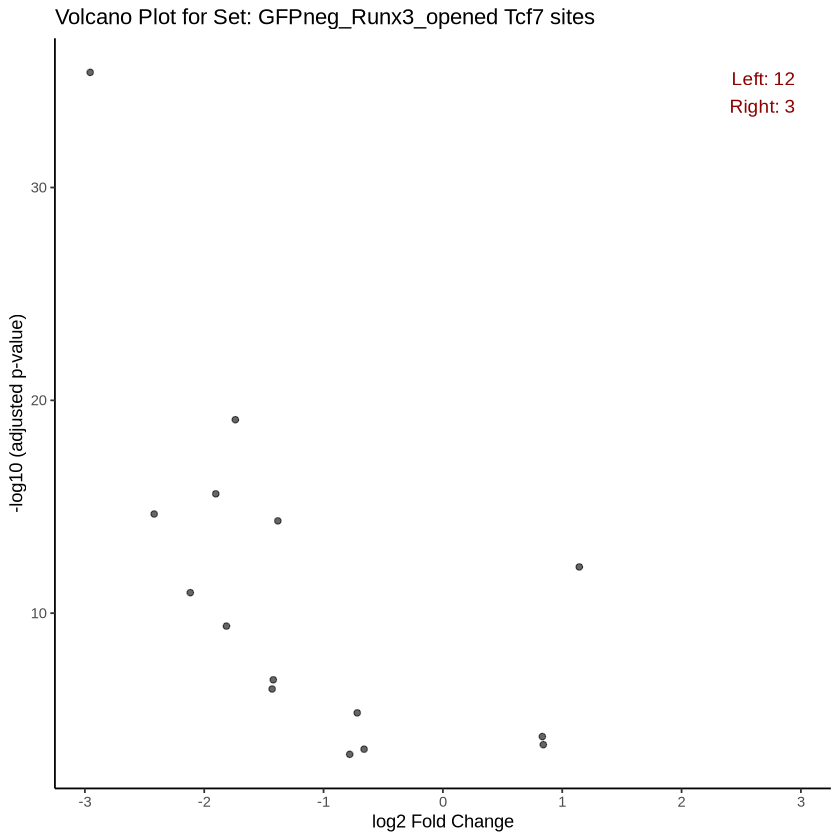

In [6]:
# This script reads a table of Tcf7 peaks from a specified file, renames the first column to "name",
# and extracts the "name" column as a vector.
# 
# 
# Steps:
# 1. Read the table from the file "../03_bp_homer/Tcf7_only.txt" with tab-separated values and a header.
# 2. Rename the first column of the table to "name".
# 3. Extract the "name" column from the table and store it in the variable `tcf7_peaks`.
tcf7_peaks <- read.table("../03_bp_homer/Tcf7_only.txt", sep = "\t", header = TRUE)
colnames(tcf7_peaks)[1] <- "name"
tcf7_peaks <- tcf7_peaks$name

# Select DAPS that have Tcf7 sites
da_daps_tcf7 <- da_daps %>%
    filter(name %in% tcf7_peaks)

# Implement
plot_volcano(da_daps_tcf7, df_daps, p_filter = 0.1, title_addendum = "Tcf7 sites")

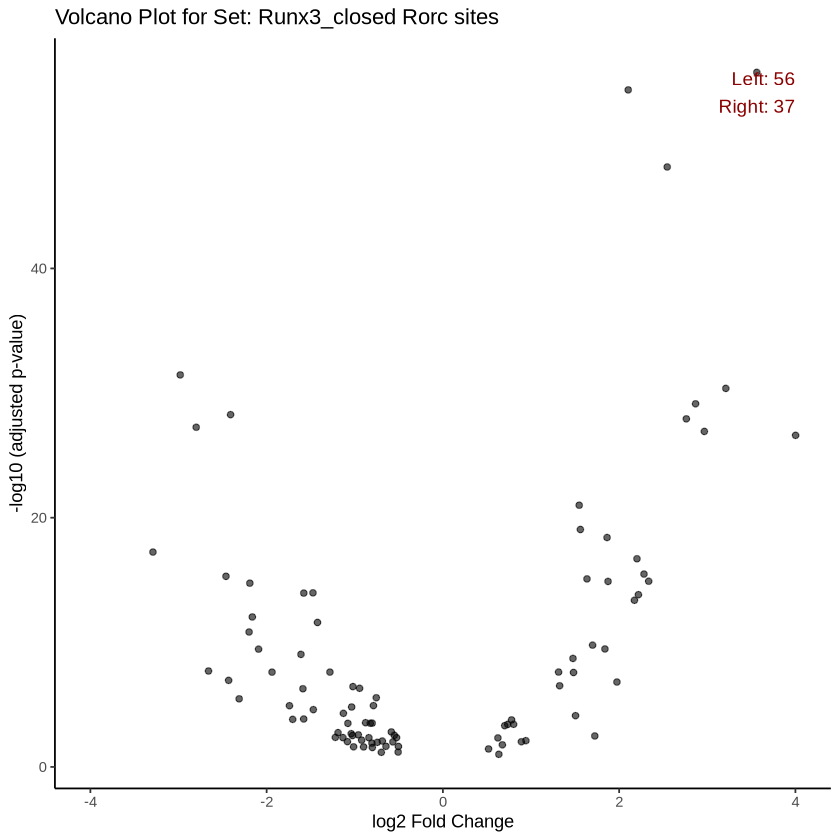

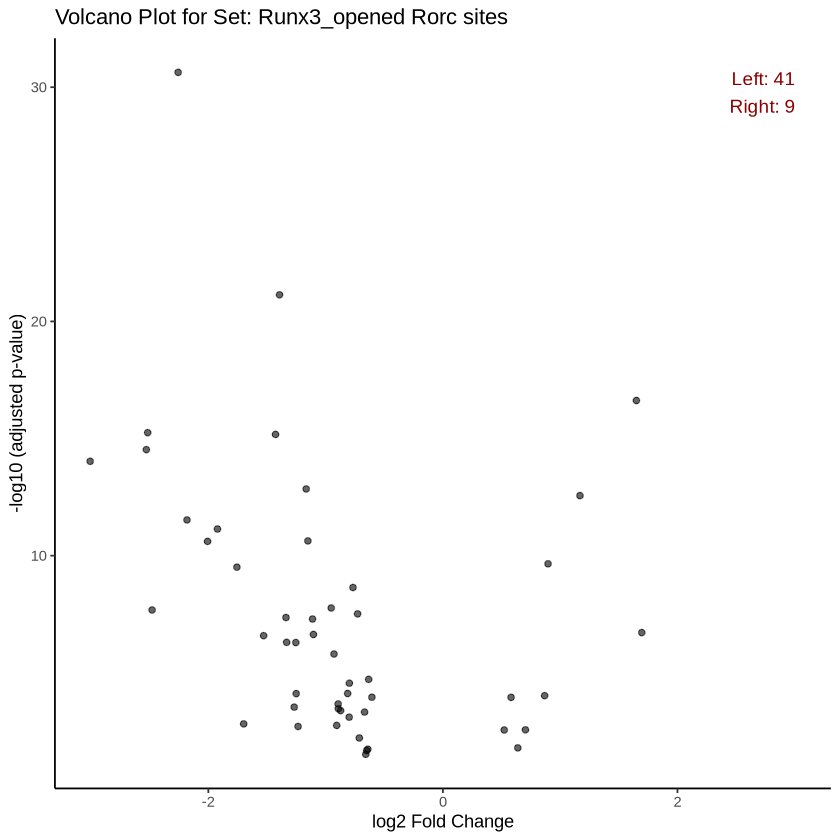

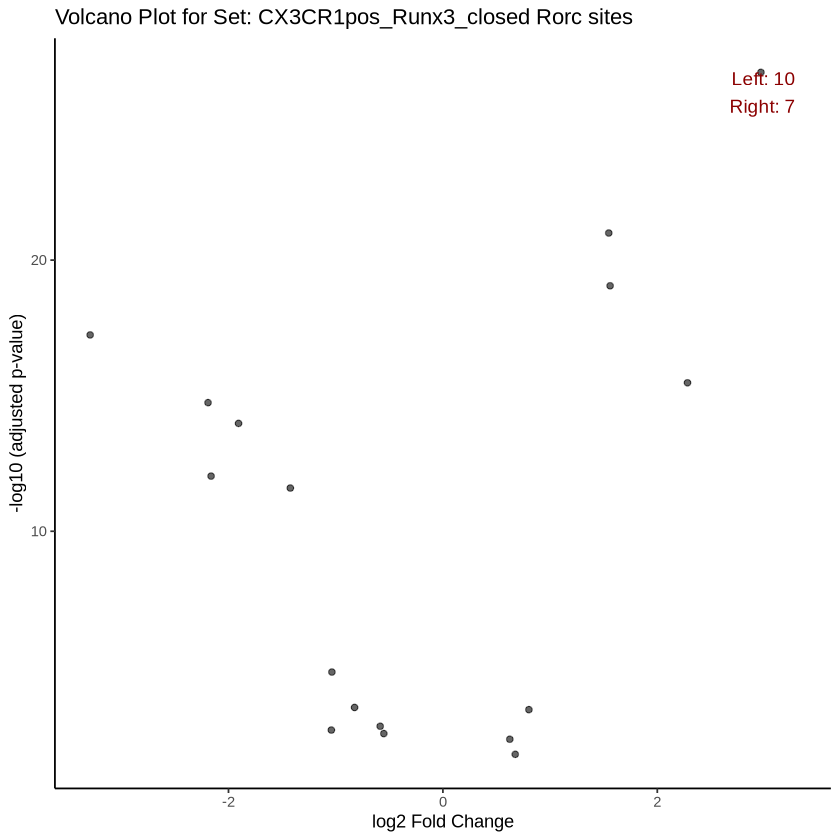

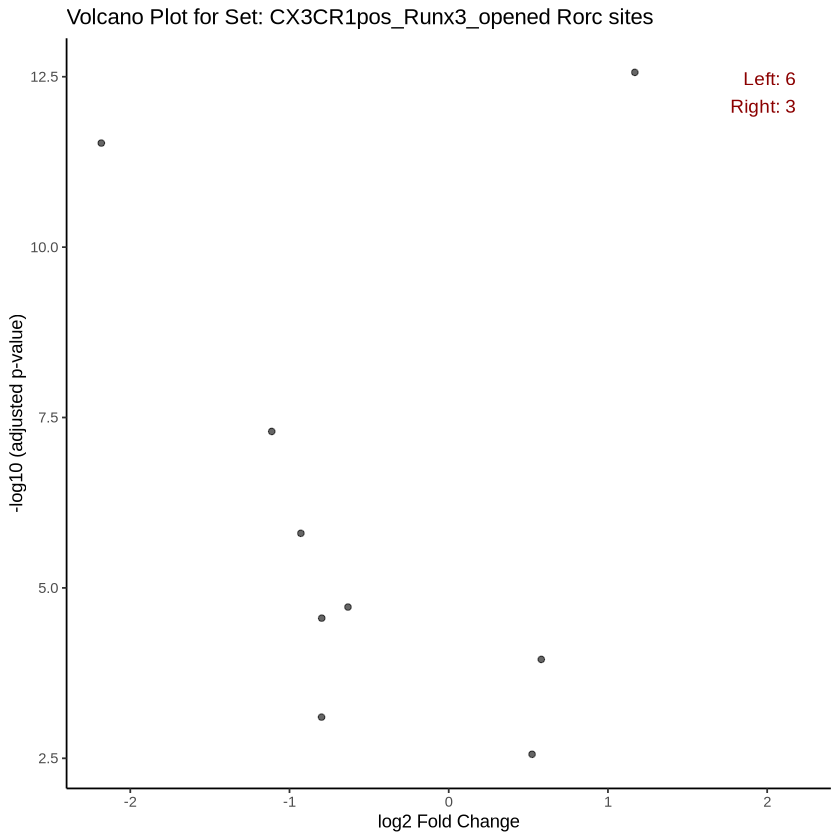

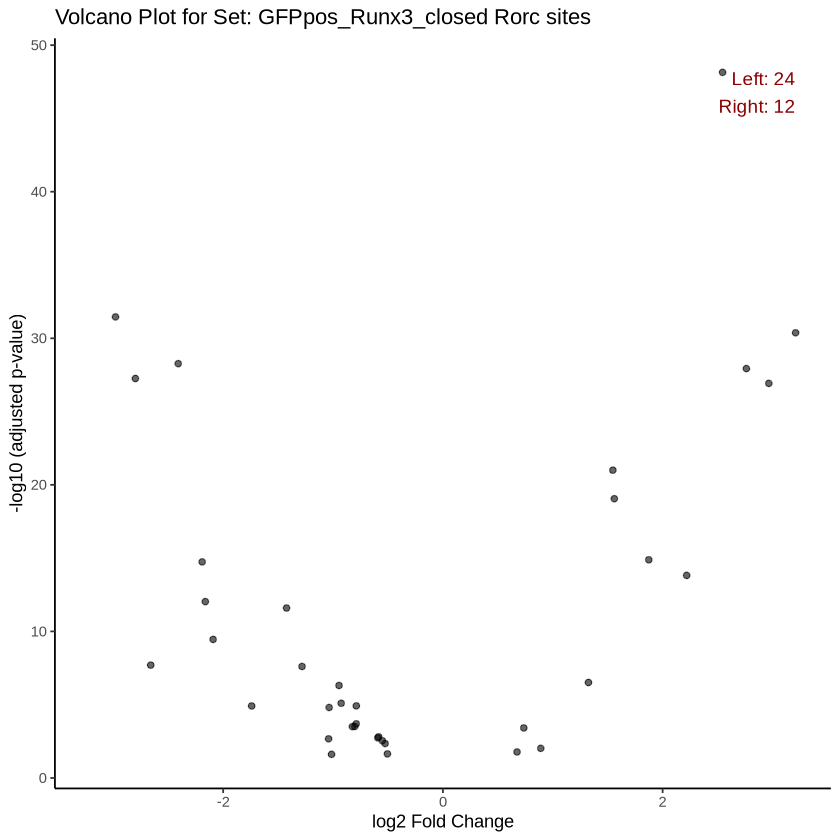

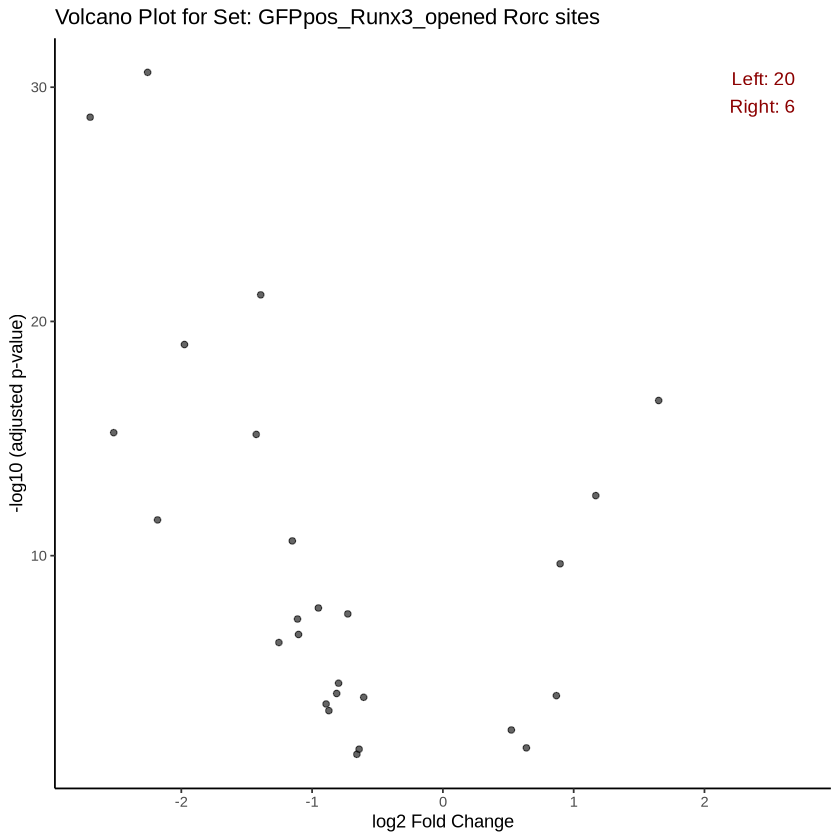

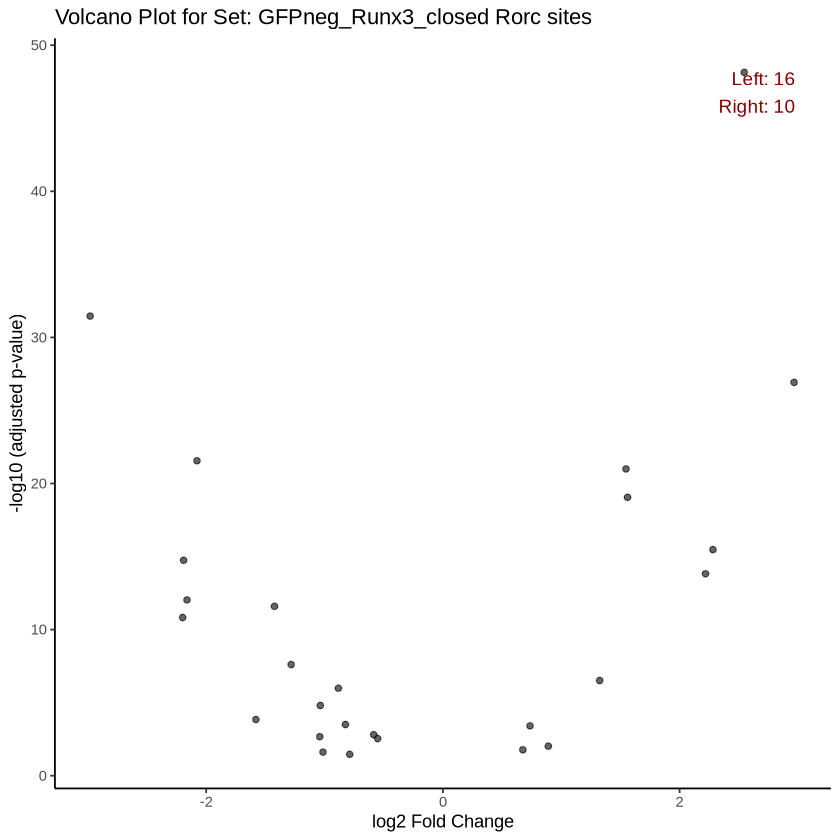

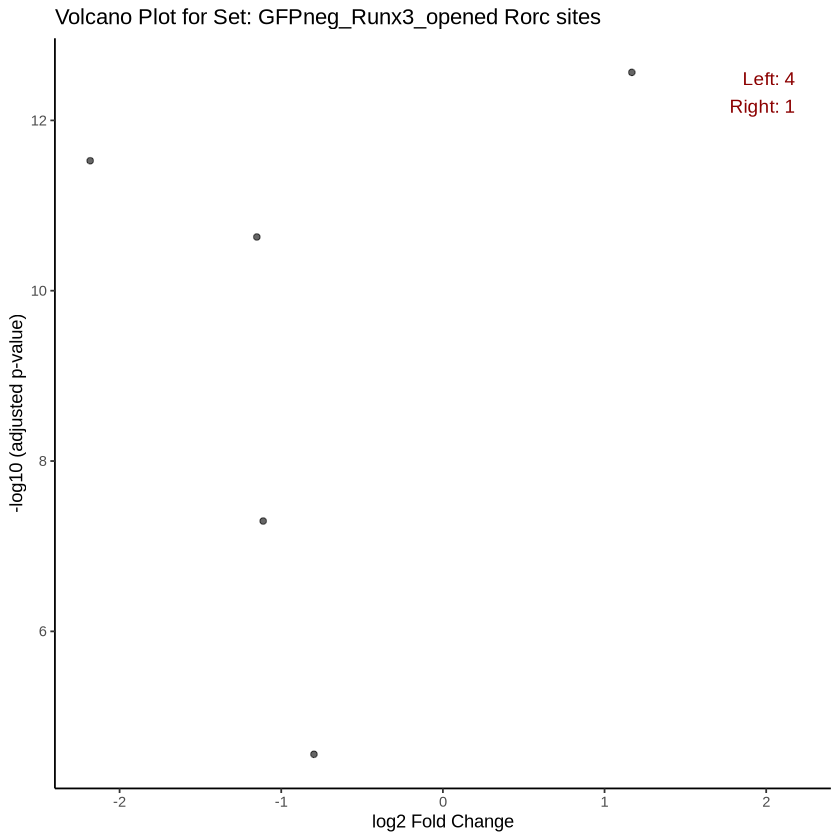

In [7]:
# This script reads a table of Tcf7 peaks from a specified file, renames the first column to "name",
# and extracts the "name" column as a vector.
# 
# 
# Steps:
# 1. Read the table from the file "../03_bp_homer/Tcf7_only.txt" with tab-separated values and a header.
# 2. Rename the first column of the table to "name".
# 3. Extract the "name" column from the table and store it in the variable `tcf7_peaks`.
rorc_peaks <- read.table("../03_bp_homer/Rorc_only.txt", sep = "\t", header = TRUE)
colnames(rorc_peaks)[1] <- "name"
rorc_peaks <- rorc_peaks$name

# Select DAPS that have Tcf7 sites
da_daps_rorc <- da_daps %>%
    filter(name %in% rorc_peaks)

# Implement
plot_volcano(da_daps_rorc, df_daps, p_filter = 0.1, title_addendum = "Rorc sites")